<a href="https://colab.research.google.com/github/StillWork/ds-lab/blob/master/gg_z_time_series_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 슈퍼마켓 매출 예측
- 가구 세일 데이터 사용


In [1]:
!curl -L https://tabsoft.co/2Y1P8oC -o Superstore.xls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   190    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 3285k    0 23360    0     0   9196      0  0:06:05  0:00:02  0:06:03 23524
 13 3285k   13  429k    0     0   120k      0  0:00:27  0:00:03  0:00:24  214k
 26 3285k   26  878k    0     0   190k      0  0:00:17  0:00:04  0:00:13  285k
 39 3285k   39 1301k    0     0   232k      0  0:00:14  0:00:05  0:00:09  321k
 52 3285k   52 1738k    0     0   264k      0  0:00:12  0:00:06  0:00:06  346k
 66 3285k   66 2187k    0     0   290k      0  0:00:11  0:00:07  0:00:04  432k
 80 3285k   80 2636k    0     0   308k      0  0:0

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
df = pd.read_excel("Superstore.xls")
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [3]:
df.shape

(9994, 21)

In [4]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

- 가구(Furniture)의 매출액만 보겠다
- 상품 Category가 Furniture인 항목만 선택한다.

In [5]:
furniture = df.loc[df['Category'] == 'Furniture']

In [6]:
furniture.shape

(2121, 21)

In [7]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

- 4년간의 데이터가 들어 있는 것을 알 수 있다.

In [8]:
# cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 
#         'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 
#         'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 
#         'Quantity', 'Discount', 'Profit']
# furniture.drop(cols, axis=1, inplace=True)


- 주문 날짜(Order Date), 판매량(Sales) : 두 column만 사용
- 날짜 순으로 정렬
- 결측치가 있는지 확인

In [9]:
furniture = furniture[["Order Date", "Sales"]]
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

- 주문 날짜를 index로 지정

In [10]:
furniture = furniture.set_index('Order Date')
furniture.shape

(2121, 1)

In [11]:
furniture[:5]

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940


### 월별 통계로 전환

#### 시계열 데이터 다루기
- https://datascienceschool.net/view-notebook/8959673a97214e8fafdb159f254185e9/

##### resample 연산
- 시간 간격을 재조정하는 리샘플링(resampling)
- 시간 구간이 작아지면 데이터 양이 증가 : 업-샘플링(up-sampling)
- 시간 구간이 커지면 데이터 양이 감소 : 다운-샘플링(down-sampling)
    - 다운-샘플링의 경우, 원래의 데이터가 그룹으로 묶이기 때문에 그룹바이(groupby)때와 같이 그룹 연산을 해서 대표값을 구해야 한다.
    - MS : 각 달의 첫날
    - 5T:5분, 1H:1시간, D(일), W(주), M(달), Y(년)
    - BM(평일 각 달의 마지막날, 주말 제외), BMS(평일 각 달의 첫날, 주말 제외)

In [12]:
y = furniture['Sales'].resample('MS').mean()
y['2017':]

Order Date
2017-01-01    248.501333
2017-02-01    264.089900
2017-03-01    286.669600
2017-04-01    206.044502
2017-05-01    319.953928
2017-06-01    372.717386
2017-07-01    227.173500
2017-08-01    395.945487
2017-09-01    349.737422
2017-10-01    308.226313
2017-11-01    374.310253
2017-12-01    296.296857
Freq: MS, Name: Sales, dtype: float64

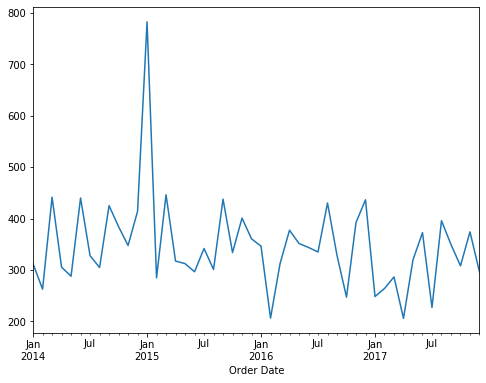

In [13]:
y.plot(figsize=(8, 6))
plt.show()

## ARIMA (판매량) 예측
### 데이터 분해
- seasonality, trend and noise: ARIMA(p, d, q): 

- seasonal_decompose()
    - Seasonal decomposition using moving averages
    - Return : A object with seasonal, trend, and resid attributes.
    - The additive model is Y[t] = T[t] + S[t] + e[t]

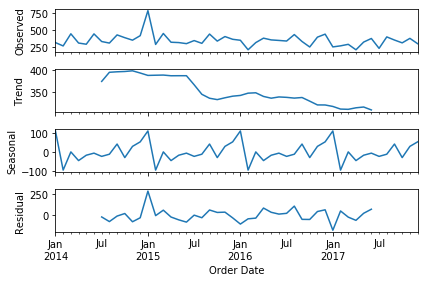

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

- itertools.product(p, d, q)
    - 곱집합(Cartesian product)
    - 예시) 두 스트링 'ABCD', 'xy' 의 곱집합 : Ax Ay Bx By Cx Cy Dx Dy

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [16]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [18]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

**굵은 텍스트**파라미터 선택

### Seasonal ARIMA 모형 추정
- https://datascienceschool.net/view-notebook/8c4f6ad9487149ca872374bbbf098e5f/

### SARIMAX
- The SARIMA model is specified (p,d,q)×(P,D,Q)s.
- enforce_stationarity
    - Whether or not to transform the AR parameters to enforce stationarity in the autoregressive component of the model. Default is True.

- enforce_invertibility
    - Whether or not to transform the MA parameters to enforce invertibility in the moving average component of the model. Default is True.

### try / except
- https://wayhome25.github.io/python/2017/02/26/py-12-exception/

In [19]:
from statsmodels.tsa.statespace import sarimax

In [20]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
#            mod = sm.tsa.statespace.SARIMAX(y,
            mod = sarimax.SARIMAX(y,
                                 order=param,
                                 seasonal_order=param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False) 
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:688.3112416991725


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1324.3661510583115
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:426.20464898591723
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.8238602501691
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:421.17561100533294
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.446456472235
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:641.1240680665791
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2769.7875462923853
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.5496453364603


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:455.1377175600285


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:411.5765686155389
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:297.44640662502263
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:580.6389269639644

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1296.1966109729015
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:433.35521367347195
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:437.46040107889746


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1300.2660181983215
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:294.1158452476943
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:538.8964721447171
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3084.5433502012793
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:412.8726989905177
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:419.1839792724932


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:273.40324546363286
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:592.7661498749849


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1252.6673399942133
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:427.7241159738327
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:420.41145389920325
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:422.29220651940875
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:273.5840395565942
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:553.2719417804335
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:3089.7987255063535
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:418.5261783089186
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:422.40035833215603
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:388.54137010693773
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:275.4775740530825
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:566.5211872508684


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1363.7299705314413
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:430.3305770817933
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:397.366898165158
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1135.6770419390914
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:273.44153987929263
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:540.6257368397364
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2511.949524294966


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:414.7726173043037
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:391.8303255654032


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2460.0839964598263
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:263.9371084381281


In [21]:
results

SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 263

In [22]:
from statsmodels.tsa.statespace import sarimax

mod = sarimax.SARIMAX(y,
                     order=(1, 1, 1),
                     seasonal_order=(1, 1, 0, 12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0771      0.259     -0.298      0.766      -0.584       0.430
ma.L1         -1.0000      0.434     -2.305      0.021      -1.850      -0.150
ar.S.L12      -0.0007      0.029     -0.025      0.980      -0.057       0.056
sigma2      6323.9741   6.86e-05   9.22e+07      0.000    6323.974    6323.974


In [23]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -127.969
Date:                            Sun, 05 Jan 2020   AIC                            263.937
Time:                                    01:19:48   BIC                            268.301
Sample:                                01-01-2014   HQIC                           264.965
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0771      0.259     -0.298      0.766      -0.584       0.430
ma.L1         -1.0000      0.434   

### 모델의 동작을 확인하기 위한 모델 검사(model diagnostics) 수행
- 아래 결과를 보면 오차가 거의 정규분포를 따른다

### results.plot_diagnostics
- Diagnostic plots for standardized residuals of one endogenous variable
- Produces a 2x2 plot grid with the following plots (ordered clockwise from top left):
    1. Standardized residuals over time

    2. Histogram plus estimated density of standardized residulas, along with a Normal(0,1) density plotted for reference.

    3. Normal Q-Q plot, with Normal reference line.

    4. Correlogram (autocorrelation, 기준 : 현재 값)

In [24]:
type(results)

statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper

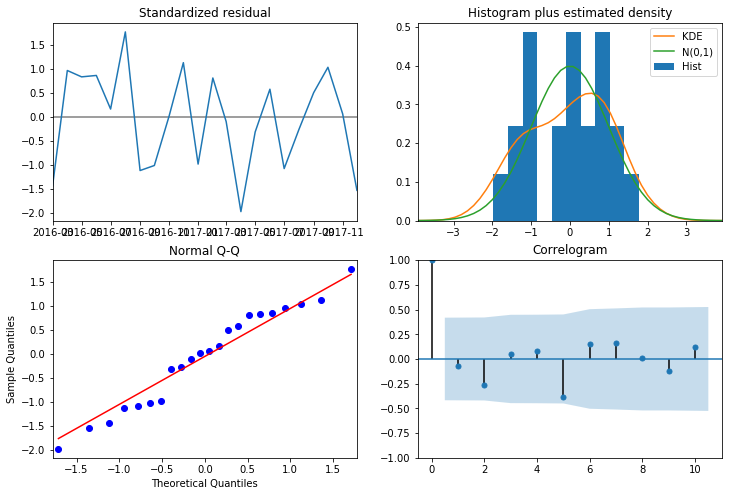

In [25]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

### 예측 수행

- pd.to_datetime() 함수를 쓰면 
    - 날짜/시간을 나타내는 문자열을 자동으로 datetime 자료형으로 바꾼 후 
    - DatetimeIndex 자료형 인덱스를 생성한다.

- get_prediction( , dynamic=False)
    - In-sample prediction and out-of-sample forecasting
    - dynamic
        - Integer offset relative to start at which to begin dynamic prediction. 
        - Can also be an absolute date string to parse or a datetime type (these are not interpreted as offsets).

- conf_int(alpha=0.05)
    - Returns the confidence interval of the fitted parameters.
    - The significance level for the confidence interval. ie., The default alpha = .05 returns a 95% confidence interval.

- fill_between(x, y1, y2=0)
    - x : The x coordinates of the nodes defining the curves.
    - y1 : The y coordinates of the nodes defining the first curve.
    - y2 : The y coordinates of the nodes defining the second curve.(default: 0)

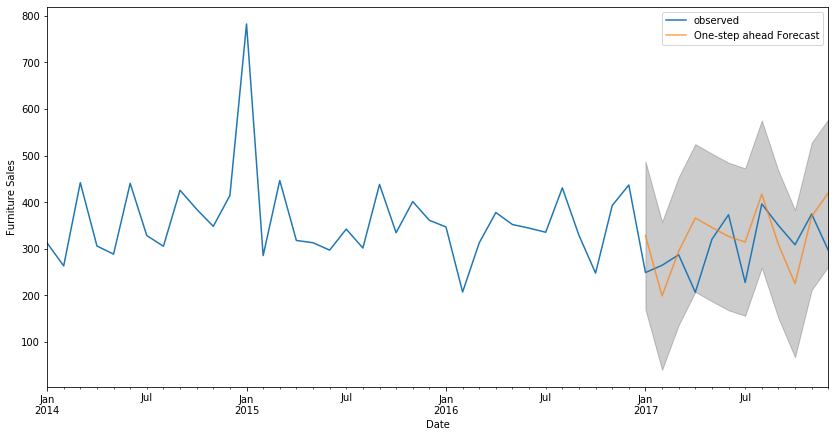

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [27]:
type(pred)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [28]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE is {}'.format(round(mse, 2)))

MSE is 5911.26


In [29]:
print('RMSE is {}'.format(round(np.sqrt(mse), 2)))

RMSE is 76.88


## 시간이 멀수록 confidence interval은 점차 증가하는 것을 볼 수 있다

- results.get_forecast()
    - Out-of-sample forecasts
    - steps : the number of steps to forecast from the end of the sample

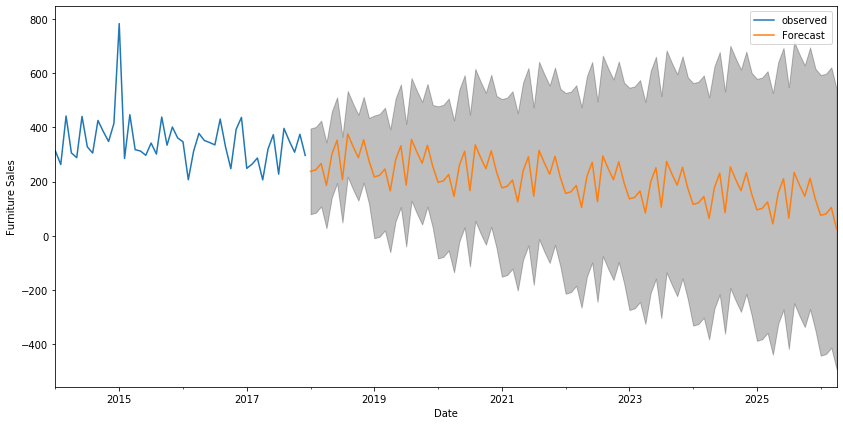

In [30]:
pred_uc = results.get_forecast(steps=100)   # 끝에서 100 개월
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


### 다른 항목의 변화와 비교
- 가구 판매량 <-> 사무용품 판매량

In [31]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [32]:
office[:3]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656


In [33]:
furniture[:3]


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310


### 가구와 사무용품의 월별 매출액 : DataFrame

In [34]:
furniture = furniture[['Order Date', 'Sales']]
office = office[['Order Date', 'Sales']]
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

In [35]:
furniture

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940
...,...,...
7636,2017-12-29,258.750
7632,2017-12-29,1207.840
5131,2017-12-29,101.120
7635,2017-12-29,300.980


In [36]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture

,Order Date,Sales
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180


In [37]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

In [38]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

In [39]:
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

In [40]:
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

In [41]:
furniture.head()

,Order Date,Sales
0,2014-01-01,480.194231
1,2014-02-01,367.931600
2,2014-03-01,857.291529
3,2014-04-01,567.488357
4,2014-05-01,432.049188


In [42]:
office.head()

,Order Date,Sales
0,2014-01-01,285.357647
1,2014-02-01,63.042588
2,2014-03-01,391.176318
3,2014-04-01,464.794750
4,2014-05-01,324.346545


- merge() 
    - 두 데이터 프레임의 공통 열 혹은 인덱스를 기준으로 두 개의 테이블을 합친다. 
    - 이 때 기준이 되는 열, 행의 데이터를 키(key)라고 한다(on=' ')
    - inner : 기본적으로는 양쪽 데이터프레임에 모두 키가 존재하는 데이터만 보여주는 inner join 방식을 사용한다
    - outer : 키 값이 한쪽에만 있어도 데이터를 보여준다.

In [43]:
store = furniture.merge(office, how='inner', on='Order Date')
store.head()

,Order Date,Sales_x,Sales_y
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


In [44]:
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


In [45]:
store.shape

(48, 3)

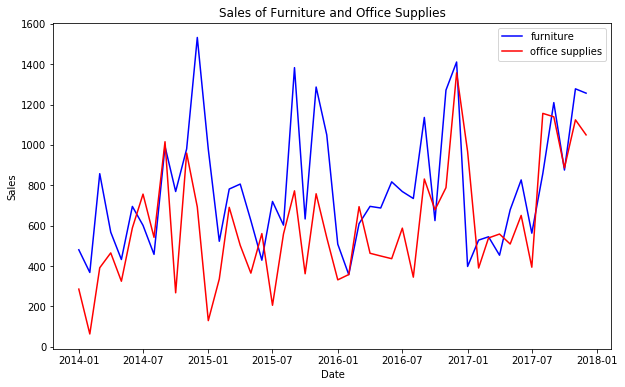

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); 
plt.title('Sales of Furniture and Office Supplies')
plt.legend();


- 유사한 계절적 특성을 갖는다.
- 사무용품 매출이 가구 매출을 앞지르는 시점을 찾아보겠다.

- np.where()
    - 조건식을 만족하는 index를 array 형태로 반환

In [47]:
np.where(store['office_sales'] > store['furniture_sales'])

(array([ 6,  7,  8, 17, 25, 26, 33, 36, 39, 43, 45], dtype=int64),)

- 반환값이 2차원 배열로 되어있다

In [48]:
np.where(store['office_sales'] > store['furniture_sales'])[0]

array([ 6,  7,  8, 17, 25, 26, 33, 36, 39, 43, 45], dtype=int64)

In [49]:
np.where(store['office_sales'] > store['furniture_sales'])[0][0]

6

In [50]:
list(np.where(store['office_sales'] > store['furniture_sales'])[0])

[6, 7, 8, 17, 25, 26, 33, 36, 39, 43, 45]

In [51]:
np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0]))

6

In [52]:
type(store)

pandas.core.frame.DataFrame

In [53]:
store.loc[6,'Order Date']

Timestamp('2014-07-01 00:00:00')

In [54]:
store.ix[6,'Order Date']

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Timestamp('2014-07-01 00:00:00')

In [55]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("사무용품 매출이 가구매출을 앞지르는 시점: {}.".format(first_date.date()))

사무용품 매출이 가구매출을 앞지르는 시점: 2014-07-01.


## Prophet
- 페이스북에서 2017년 발표
- 시간 간격이 다른 샘플을 같이 분석 가능
- 휴일 등의 변수를 사용할 수 있다.
- 공식 사이트 : https://facebook.github.io/prophet/
- 논문 : https://peerj.com/preprints/3190.pdf
- 요약(한글) : https://gorakgarak.tistory.com/1255

- Install Error
``` python
!pip install fbprophet
```
- Anacond Prompt에서 OK!!!
``` python
conda install -c conda-forge fbprophet
```

In [56]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [57]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [58]:
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- make_future_dataframe(periods=36, freq='MS')
    - Make dataframe with future dates for forecasting
    - periods : Int number of periods to forecast forward
    - freq : 'day', 'week', 'month', 'quarter', 'year', 1(1 sec), 60(1 minute) or 3600(1 hour)

In [59]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

In [60]:
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1296x432 with 0 Axes>

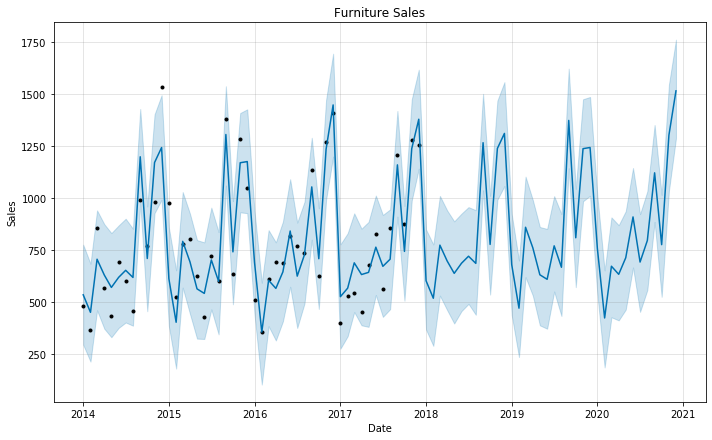

In [61]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

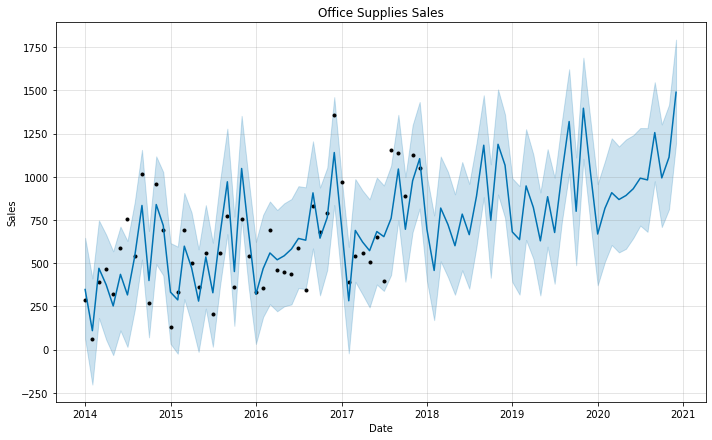

In [62]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');